# Decorrelated Random Forests for Image Classification

## Import Libraries

In [1]:
%matplotlib inline
import htcv

import math
import numpy as np
import scipy.io
from matplotlib import pyplot as plt

## Load USPS Data

In [2]:
def load_usps_data(fname):
    ''' Loads USPS (United State Postal Service) data from <fname>
    Definition:  X, Y = load_usps_data(fname)
    Input:       fname   - string
    Output:      X       -  DxN array with N images with D pixels
                 Y       -  10xN array with labels
    '''
    # load the data
    data = scipy.io.loadmat(fname)
    # extract images and labels
    X = data['data_patterns']
    Y = data['data_labels']
    return X, Y

In [3]:
X_raw,Y_raw = load_usps_data('data/usps.mat')
img_width = int(X_raw.shape[0] ** .5)

X = np.transpose(X_raw.reshape(img_width, img_width, -1), (2,0,1))
Y = Y_raw > 0

X.shape,X.dtype,Y.shape,Y.dtype

((2007, 16, 16), dtype('<f8'), (10, 2007), dtype('bool'))

## Example of image from the dataset

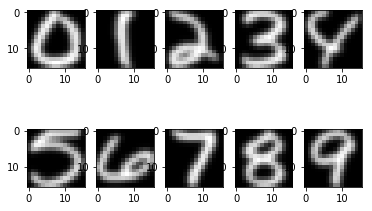

In [4]:
idx_examples = [Y[i].nonzero()[0][0] for i in range(10)]
for i,idx in enumerate(idx_examples):
    plt.subplot(2, 5, i+1)
    plt.imshow(X[idx], cmap='gray')

## Train a Random Forest

In [5]:
X_train = X
Y_train = Y.argmax(axis=0).astype(np.uint8)

X_train.shape,Y_train.shape,Y_train.dtype

((2007, 16, 16), (2007,), dtype('uint8'))

In [6]:
# Force always the same results
np.random.seed(0)
htcv.NUM_CLASSES = 10

trees,subsets,_ = htcv.fit(X_train, Y_train, num_trees=10,
                         height=5, sample_size=X_train.shape[0] // 4)

## Evaluate the RF in the training set

In [7]:
def error_rate(predictions, Y):
    predicted_classes = predictions.argmax(axis=1)
    return np.count_nonzero(predicted_classes != Y) / Y.size

In [8]:
predictions,_ = htcv.predictFromForest(X_train, trees)
error_rate(predictions, Y_train)

0.25959142999501744

## Colect Out-of-bag generalization error

In [9]:
oob_idx,oob_predictions,Qxy,Qxj_hat,p = htcv.out_of_bag_prediction(
    trees,
    subsets,
    X_train,
    Y_train)

error_rate(oob_predictions[oob_idx], Y_train[oob_idx])

0.29895366218236175

## Colect Out-of-bag strength and correlation

In [10]:
s,ro = htcv.strength_correlation(Qxy[oob_idx], Qxj_hat[oob_idx], p[:2], Y_train[oob_idx])

print("Strength:\t %.5f" % s)
print("Correlation:\t %.5f" % ro)
print("c/s² Ratio:\t %.5f" % (ro / s**2 if s>0 else np.inf))

Strength:	 0.23565
Correlation:	 0.23469
c/s² Ratio:	 4.22633
